In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow_hub as hub
import numpy as np

In [3]:
%cd /content/drive/My\ Drive/quora-question-pairs/

/content/drive/My Drive/quora-question-pairs


In [4]:
# ! wget -O universal-sentence-encoder_4.tar.gz https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed
# ! tar -xvzf universal-sentence-encoder_4.tar.gz

In [5]:
train = pd.read_csv("input/train.csv")

In [6]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
train.dropna(subset = ["question1", "question2"], inplace=True)

Imbalanced dataset.

In [8]:
train.is_duplicate.value_counts() / train.shape[0]

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

In [10]:
# Universal Sentence Encoder model is assumed to be in the `use_model` directory. If not use :-
# use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_embed = hub.load("./use_model")

In [11]:
emb = use_embed([
    "I like to play table tennis.","What is the step by step guide to invest in share market in india?"])

In [12]:
emb

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.04213703, -0.04533162, -0.06854989, ..., -0.00679459,
        -0.05816485, -0.0583573 ],
       [ 0.00218214, -0.07132352, -0.0089497 , ..., -0.01341303,
        -0.04243164, -0.08003797]], dtype=float32)>

In [13]:
def row_wise_cos_sim(embeddings1, embeddings2):
  """
  Takes in 2 matrices of same dimensions, and returns row-wise cosine similarity.
  """
  return np.sum(embeddings1*embeddings2, axis=1) / (np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1))

In [14]:
train.shape

(404287, 6)

In [15]:
# This list is used to store cosine similarities of `question_1` and `question_2` in the train dataset.
cosine_similarities = []

In [16]:
# Going through the dataset in batches
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for question_1_batch, question_2_batch in zip(batch(train.question1, 100000), batch(train.question2, 100000)):
    question1_embeddings = use_embed(question_1_batch)
    question2_embeddings = use_embed(question_2_batch)
    cosine_similarities += list(row_wise_cos_sim(question1_embeddings, question2_embeddings))


In [ ]:
len(cosine_similarities)

404287

In [ ]:
train['Cosine_Similarity'] = pd.Series(cosine_similarities)

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,Cosine_Similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.936438
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.684389
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.609381
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.124987
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.335715


In [ ]:
train.groupby(['is_duplicate']).mean()[["Cosine_Similarity"]]

,Cosine_Similarity
is_duplicate,
0,0.653828
1,0.716266


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd23cdbd4e0>,
      dtype=object)

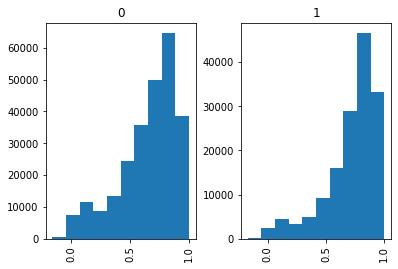

In [ ]:
train['Cosine_Similarity'].hist(by=train['is_duplicate'])

In [ ]:
best_accuracy = 0
best_threshold = 0.65
for threshold in np.arange(0.65, 1.0, 0.01):
  predictions = train.Cosine_Similarity.apply(lambda x: 1 if x > threshold else 0)
  accuracy = np.sum(train.is_duplicate == predictions) / train.shape[0]
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_threshold = threshold

In [ ]:
best_accuracy

0.6309181348893237

Best threshold is 1 because of the imbalance, F1 might be a better metric to optimize for.

In [ ]:
best_threshold

0.9900000000000003

In [ ]:
test = pd.read_csv("input/test.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
test.dropna(subset = ["question1", "question2"], inplace=True)

In [ ]:
cosine_similarities_test = []

In [ ]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for question_1_batch, question_2_batch in zip(batch(test.question1, 100000), batch(test.question2, 100000)):
    question1_embeddings = use_embed(question_1_batch)
    question2_embeddings = use_embed(question_2_batch)
    cosine_similarities_test += list(row_wise_cos_sim(question1_embeddings, question2_embeddings))


In [ ]:
test['Cosine_Similarity'] = pd.Series(cosine_similarities_test)

In [ ]:
test.head()

,test_id,question1,question2,Cosine_Similarity
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.451110
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.731495
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.747068
3,3,Which food not emulsifiers?,What foods fibre?,0.592100
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.626594


In [ ]:
test = test.rename({'Cosine_Similarity': 'is_duplicate'}, axis=1)

In [ ]:
test.to_csv('submission.csv', columns=['test_id','is_duplicate'], index=False)